# Time series forecasting

# Initial setup

## Import required packages

In [307]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Import time series data: Airline passenger traffic

In [308]:
data = pd.read_csv('UNRATE.csv', header = None)
data.columns = ['Month','Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%d-%m-%Y')
data = data.set_index('Month')
data.head(12)

#len(data)

,Passengers
Month,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
1948-06-01,3.6
1948-07-01,3.6
1948-08-01,3.9
1948-09-01,3.8


# Time series analysis

## Plot time series data

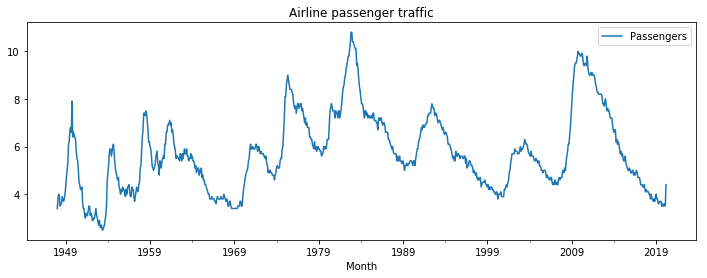

In [309]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

## Missing value treatment

### Mean imputation

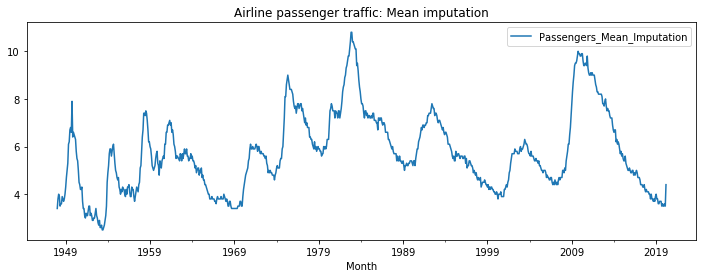

In [310]:
data = data.assign(Passengers_Mean_Imputation=data.Passengers.fillna(data.Passengers.mean()))
data[['Passengers_Mean_Imputation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Mean imputation')
plt.show(block=False)

### Linear interpolation

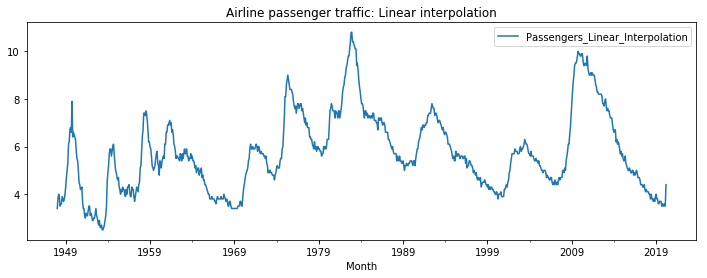

In [311]:
data = data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Linear interpolation')
plt.show(block=False)

### Use linear interpolation to impute missing values

In [312]:
data['Passengers'] = data['Passengers_Linear_Interpolation']
data.drop(columns=['Passengers_Mean_Imputation','Passengers_Linear_Interpolation'],inplace=True)

## Outlier detection

### Box plot and interquartile range

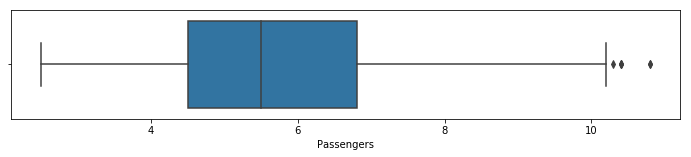

In [313]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Passengers'],whis=1.5)

### Histogram plot

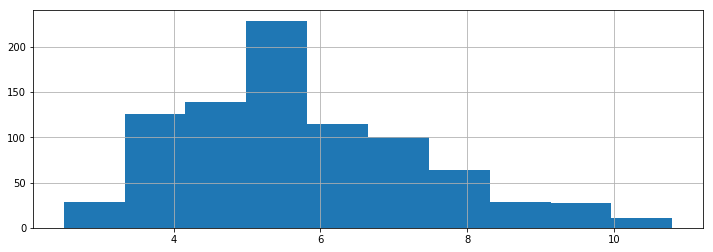

In [314]:
fig = data.Passengers.hist(figsize = (12,4))

## Time series Decomposition

### Additive seasonal decomposition

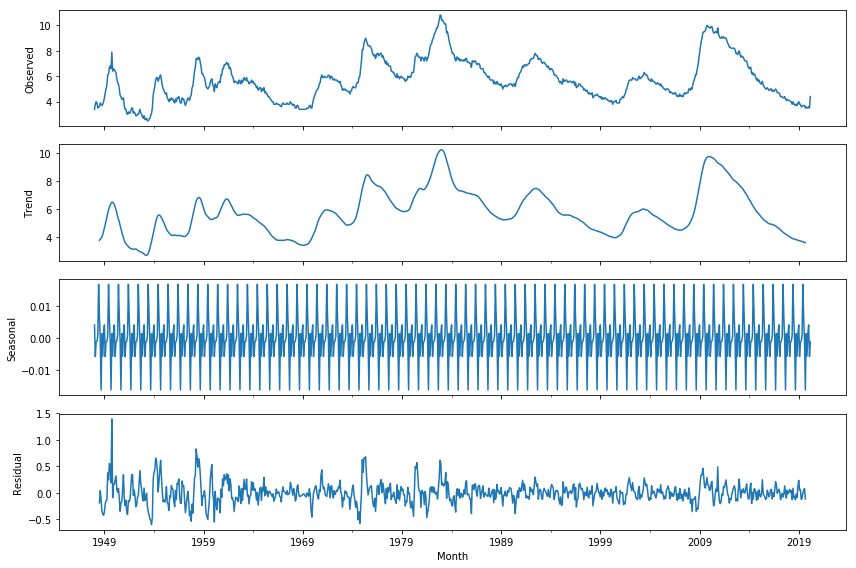

In [315]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### Multiplicative seasonal decomposition

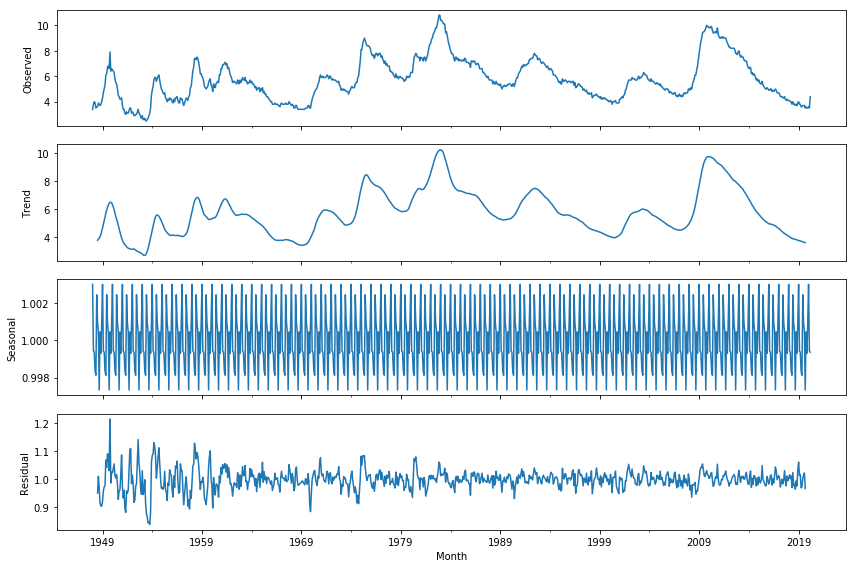

In [316]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

# Build and evaluate time series forecast

## Split time series data into training and test set

In [317]:
train_len = 612
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

# Simple time series methods

## Naive method

In [318]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

### Plot train, test and forecast

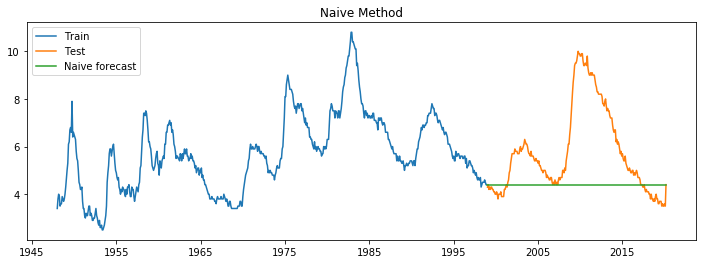

In [319]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

### Calculate RMSE and MAPE

In [320]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.5


## Simple average method

In [321]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

### Plot train, test and forecast

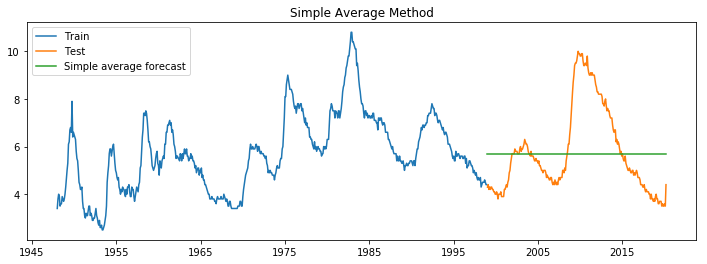

In [322]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

### Calculate RMSE and MAPE

In [323]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.50
0,Simple average method,1.80,24.82


## Simple moving average method

In [324]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plot train, test and forecast

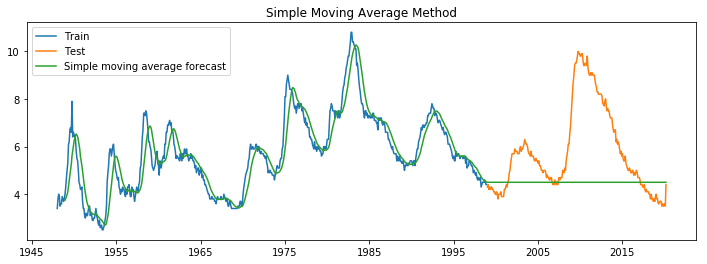

In [325]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [326]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.50
0,Simple average method,1.80,24.82
0,Simple moving average forecast,2.21,21.99


# Exponential smoothing methods

## Simple exponential smoothing

In [327]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(255)


### Plot train, test and forecast

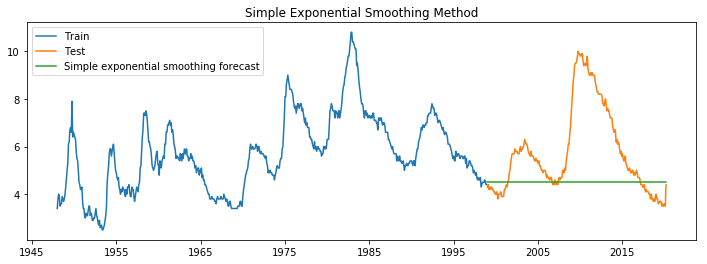

In [328]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [329]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.50
0,Simple average method,1.80,24.82
0,Simple moving average forecast,2.21,21.99
0,Simple exponential smoothing forecast,2.21,22.01


## Holt's method with trend

In [330]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 3.4, 'initial_slope': 0.3999999999999999, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

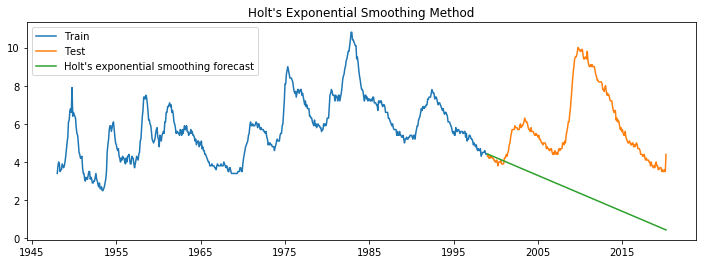

In [331]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RSME and MAPE

In [332]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.50
0,Simple average method,1.80,24.82
0,Simple moving average forecast,2.21,21.99
0,Simple exponential smoothing forecast,2.21,22.01
0,Holt's exponential smoothing method,3.99,55.15


## Holt Winters' additive method with trend and seasonality

In [333]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(255)

{'smoothing_level': 0.810070192228266, 'smoothing_slope': 0.3465020867493514, 'smoothing_seasonal': 0.0, 'damping_slope': nan, 'initial_level': 5.3500410326260495, 'initial_slope': 0.1137942359214104, 'initial_seasons': array([-1.97444893, -1.98111961, -1.96794951, -1.97022974, -1.97619261,
       -1.96622582, -1.97366507, -1.98674618, -1.99174746, -1.97297555,
       -1.98730011, -1.97588725]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

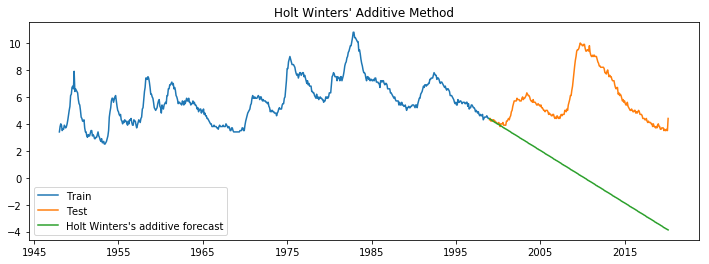

In [334]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE

In [335]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.50
0,Simple average method,1.80,24.82
0,Simple moving average forecast,2.21,21.99
0,Simple exponential smoothing forecast,2.21,22.01
0,Holt's exponential smoothing method,3.99,55.15
0,Holt Winters' additive method,6.32,95.93


## Holt Winter's multiplicative method with trend and seasonality

In [336]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(255)

{'smoothing_level': 0.8093612786231397, 'smoothing_slope': 0.34717544016821655, 'smoothing_seasonal': 0.0, 'damping_slope': nan, 'initial_level': 5.616717706442375, 'initial_slope': 0.18801452452385908, 'initial_seasons': array([0.60118628, 0.60119157, 0.60245702, 0.60265157, 0.6024597 ,
       0.60282737, 0.60170072, 0.60020107, 0.59965806, 0.60257805,
       0.60072875, 0.60203646]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

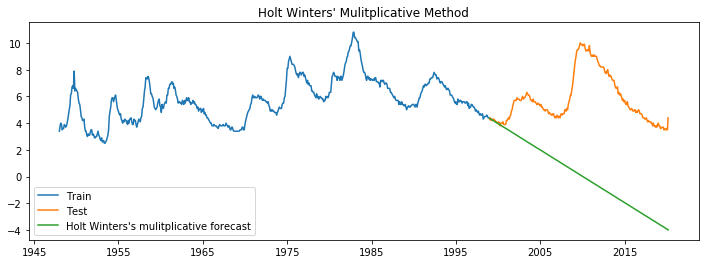

In [337]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

### Calculate RMSE and MAPE

In [338]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.50
0,Simple average method,1.80,24.82
0,Simple moving average forecast,2.21,21.99
0,Simple exponential smoothing forecast,2.21,22.01
0,Holt's exponential smoothing method,3.99,55.15
0,Holt Winters' additive method,6.32,95.93
0,Holt Winters' multiplicative method,6.38,96.88


# Auto Regressive methods

## Stationarity vs non-stationary time series

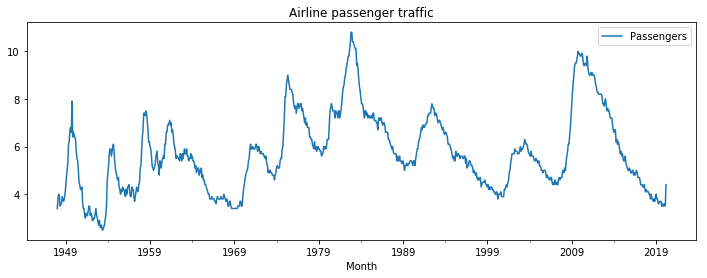

In [339]:
data['Passengers'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

### Augmented Dickey-Fuller (ADF) test

In [340]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Passengers'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.143963
Critical Values @ 0.05: -2.86
p-value: 0.023466


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [341]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Passengers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.464446
Critical Values @ 0.05: 0.46
p-value: 0.049674


### Box Cox transformation to make variance constant

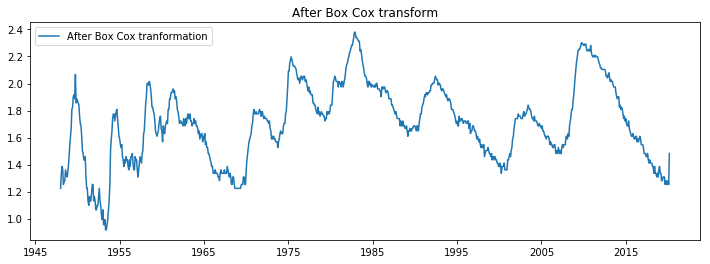

In [342]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

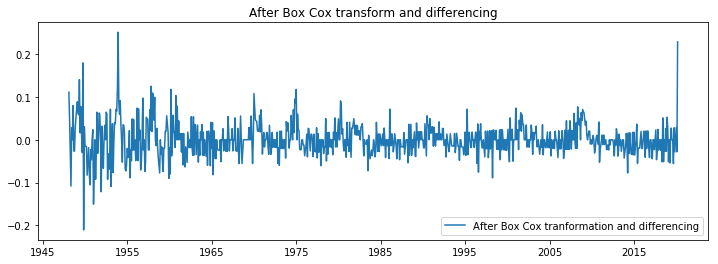

In [343]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [344]:
data_boxcox_diff.dropna(inplace=True)

In [345]:
data_boxcox_diff.tail()

Month
2019-11-01   -0.028171
2019-12-01    0.000000
2020-01-01    0.028171
2020-02-01   -0.028171
2020-03-01    0.228842
dtype: float64

In [346]:
data_boxcox_diff.index.dtype

dtype('<M8[ns]')

### Augmented Dickey-Fuller (ADF) test

In [347]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -8.918955
Critical Values @ 0.05: -2.86
p-value: 0.000000


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [348]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.062761
Critical Values @ 0.05: 0.46
p-value: 0.100000


## Autocorrelation function (ACF)

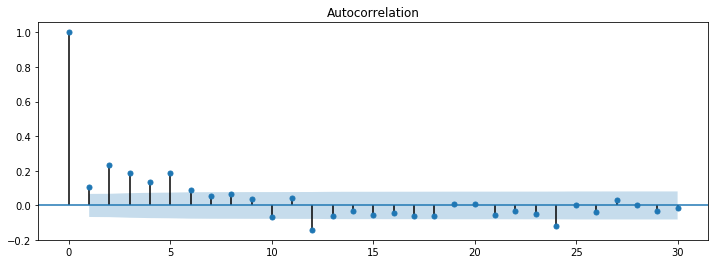

In [349]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

## Partial autocorrelation function (PACF)

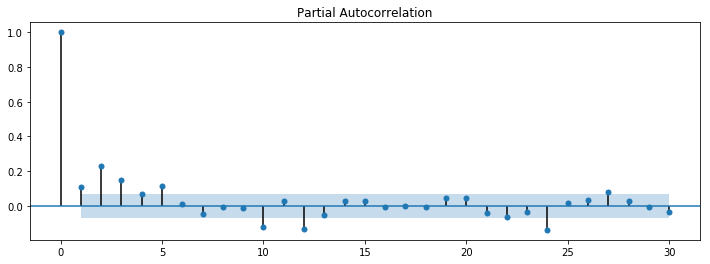

In [350]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [351]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [352]:
train_data_boxcox_diff

Month
1948-02-01    0.111226
1948-03-01    0.051293
1948-04-01   -0.025318
1948-05-01   -0.108214
1948-06-01    0.028171
1948-07-01    0.000000
1948-08-01    0.080043
1948-09-01   -0.025975
1948-10-01   -0.026668
1948-11-01    0.026668
1948-12-01    0.051293
1949-01-01    0.072321
1949-02-01    0.088947
1949-03-01    0.061875
1949-04-01    0.058269
1949-05-01    0.140582
1949-06-01    0.016261
1949-07-01    0.077558
1949-08-01    0.014815
1949-09-01   -0.029853
1949-10-01    0.179793
1949-11-01   -0.210565
1949-12-01    0.030772
1950-01-01   -0.015267
1950-02-01   -0.015504
1950-03-01   -0.015748
1950-04-01   -0.082692
1950-05-01   -0.053110
1950-06-01   -0.018349
1950-07-01   -0.076961
                ...   
1996-07-01    0.037041
1996-08-01   -0.075508
1996-09-01    0.019418
1996-10-01    0.000000
1996-11-01    0.037740
1996-12-01    0.000000
1997-01-01   -0.018692
1997-02-01   -0.019048
1997-03-01    0.000000
1997-04-01   -0.019418
1997-05-01   -0.040005
1997-06-01    0.020203
1997-

## Auto regression method (AR)

In [353]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(5, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.000573
ar.L1.y    0.053734
ar.L2.y    0.180799
ar.L3.y    0.125658
ar.L4.y    0.072196
ar.L5.y    0.083696
dtype: float64


### Recover original time series

In [354]:
print(data_boxcox_diff.index.min())
print(data_boxcox_diff.index.max())
data_boxcox_diff.dtypes
data_boxcox_diff.index.dtype

1948-02-01 00:00:00
2020-03-01 00:00:00


dtype('<M8[ns]')

In [355]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot train, test and forecast

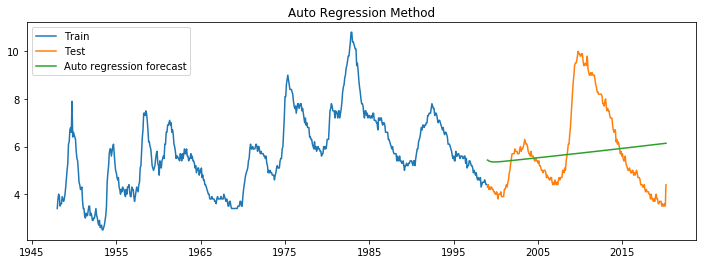

In [356]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE

In [357]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ar['ar_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.50
0,Simple average method,1.80,24.82
0,Simple moving average forecast,2.21,21.99
0,Simple exponential smoothing forecast,2.21,22.01
0,Holt's exponential smoothing method,3.99,55.15
0,Holt Winters' additive method,6.32,95.93
0,Holt Winters' multiplicative method,6.38,96.88
0,Autoregressive (AR) method,1.81,25.38


In [358]:
y_hat_ar['ar_forecast']

1948-02-01    3.902235
1948-03-01    3.963161
1948-04-01    4.086663
1948-05-01    4.192675
1948-06-01    4.212735
1948-07-01    4.179406
1948-08-01    4.155393
1948-09-01    4.147864
1948-10-01    4.174203
1948-11-01    4.201691
1948-12-01    4.199185
1949-01-01    4.238538
1949-02-01    4.292662
1949-03-01    4.398124
1949-04-01    4.553447
1949-05-01    4.716991
1949-06-01    4.902705
1949-07-01    5.132479
1949-08-01    5.312296
1949-09-01    5.485946
1949-10-01    5.619413
1949-11-01    5.695008
1949-12-01    5.840806
1950-01-01    5.756943
1950-02-01    5.694209
1950-03-01    5.696467
1950-04-01    5.579804
1950-05-01    5.538176
1950-06-01    5.418191
1950-07-01    5.294272
                ...   
2017-10-01    6.037593
2017-11-01    6.041052
2017-12-01    6.044514
2018-01-01    6.047978
2018-02-01    6.051443
2018-03-01    6.054911
2018-04-01    6.058380
2018-05-01    6.061851
2018-06-01    6.065325
2018-07-01    6.068800
2018-08-01    6.072278
2018-09-01    6.075757
2018-10-01 

## Moving average method (MA)

In [359]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 5)) 
model_fit = model.fit()
print(model_fit.params)

const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


### Recover original time series

In [360]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast

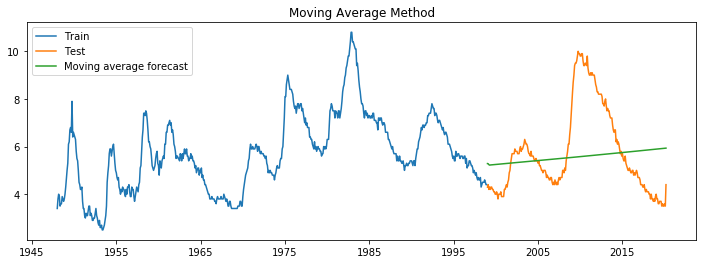

In [361]:
plt.figure(figsize=(12,4))
plt.plot(data['Passengers'][:train_len], label='Train')
plt.plot(data['Passengers'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [362]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ma['ma_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.50
0,Simple average method,1.80,24.82
0,Simple moving average forecast,2.21,21.99
0,Simple exponential smoothing forecast,2.21,22.01
0,Holt's exponential smoothing method,3.99,55.15
0,Holt Winters' additive method,6.32,95.93
0,Holt Winters' multiplicative method,6.38,96.88
0,Autoregressive (AR) method,1.81,25.38
0,Moving Average (MA) method,1.82,24.26


In [363]:
y_hat_ma['ma_forecast']

1948-02-01    3.901980
1948-03-01    3.950280
1948-04-01    4.057868
1948-05-01    4.143129
1948-06-01    4.141527
1948-07-01    4.109965
1948-08-01    4.074681
1948-09-01    4.034847
1948-10-01    4.035718
1948-11-01    4.084505
1948-12-01    4.102314
1949-01-01    4.161209
1949-02-01    4.198595
1949-03-01    4.277789
1949-04-01    4.414816
1949-05-01    4.561282
1949-06-01    4.716618
1949-07-01    4.903868
1949-08-01    5.013272
1949-09-01    5.113709
1949-10-01    5.195431
1949-11-01    5.200197
1949-12-01    5.292469
1950-01-01    5.171886
1950-02-01    5.100280
1950-03-01    5.137236
1950-04-01    4.981139
1950-05-01    4.961436
1950-06-01    4.895105
1950-07-01    4.809551
                ...   
2017-10-01    5.847127
2017-11-01    5.850095
2017-12-01    5.853064
2018-01-01    5.856035
2018-02-01    5.859007
2018-03-01    5.861981
2018-04-01    5.864956
2018-05-01    5.867933
2018-06-01    5.870911
2018-07-01    5.873891
2018-08-01    5.876873
2018-09-01    5.879856
2018-10-01 

## Auto regression moving average method (ARMA)

In [368]:
model = ARIMA(train_data_boxcox_diff, order=(1,0,1))
model_fit = model.fit()
print(model_fit.params)

const      0.000572
ar.L1.y    0.841698
ma.L1.y   -0.687152
dtype: float64


In [365]:
data_boxcox_diff.index.min()

Timestamp('1948-02-01 00:00:00')

In [366]:
data_boxcox_diff.index.max()

Timestamp('2020-03-01 00:00:00')

### Recover original time series

In [369]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

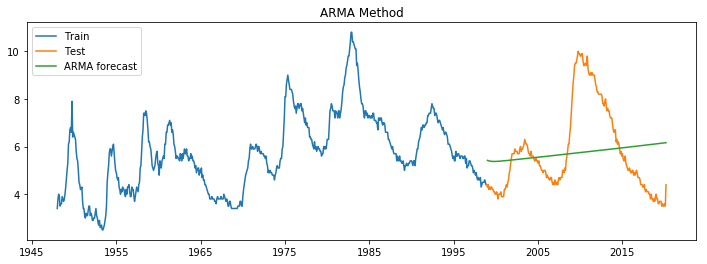

In [370]:
plt.figure(figsize=(12,4))
plt.plot( data['Passengers'][:train_len-1], label='Train')
plt.plot(data['Passengers'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Calculate RMSE and MAPE

In [371]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arma['arma_forecast'][train_len-1:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.50
0,Simple average method,1.80,24.82
0,Simple moving average forecast,2.21,21.99
0,Simple exponential smoothing forecast,2.21,22.01
0,Holt's exponential smoothing method,3.99,55.15
0,Holt Winters' additive method,6.32,95.93
0,Holt Winters' multiplicative method,6.38,96.88
0,Autoregressive (AR) method,1.81,25.38
0,Moving Average (MA) method,1.82,24.26
0,Autoregressive moving average (ARMA) method,1.81,25.53


## Auto regressive integrated moving average (ARIMA)

In [372]:
model = ARIMA(train_data_boxcox, order=(12, 1, 5))
model_fit = model.fit()
print(model_fit.params)

const         0.000452
ar.L1.D.y    -0.433467
ar.L2.D.y     0.808283
ar.L3.D.y     0.773695
ar.L4.D.y    -0.552142
ar.L5.D.y    -0.809446
ar.L6.D.y     0.075672
ar.L7.D.y     0.063787
ar.L8.D.y     0.067391
ar.L9.D.y     0.186424
ar.L10.D.y    0.020918
ar.L11.D.y   -0.071383
ar.L12.D.y   -0.069257
ma.L1.D.y     0.462017
ma.L2.D.y    -0.639004
ma.L3.D.y    -0.600141
ma.L4.D.y     0.623412
ma.L5.D.y     0.870213
dtype: float64


### Recover original time series forecast

In [373]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

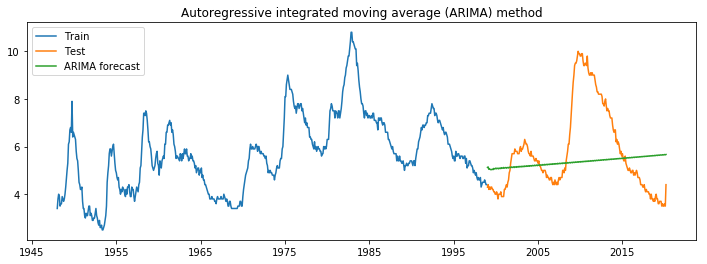

In [374]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [375]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arima['arima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.50
0,Simple average method,1.80,24.82
0,Simple moving average forecast,2.21,21.99
0,Simple exponential smoothing forecast,2.21,22.01
0,Holt's exponential smoothing method,3.99,55.15
0,Holt Winters' additive method,6.32,95.93
0,Holt Winters' multiplicative method,6.38,96.88
0,Autoregressive (AR) method,1.81,25.38
0,Moving Average (MA) method,1.82,24.26
0,Autoregressive moving average (ARMA) method,1.81,25.53


## Seasonal auto regressive integrated moving average (SARIMA)

In [376]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(2, 1, 4), seasonal_order=(2, 1, 4, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.602833
ar.L2       0.117394
ma.L1      -0.561799
ma.L2      -0.002964
ma.L3       0.069145
ma.L4       0.058013
ar.S.L12   -0.942947
ar.S.L24   -0.510354
ma.S.L12   -0.272060
ma.S.L24   -0.551290
ma.S.L36   -0.397163
ma.S.L48    0.272868
sigma2      0.001504
dtype: float64


### Recover original time series forecast

In [377]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

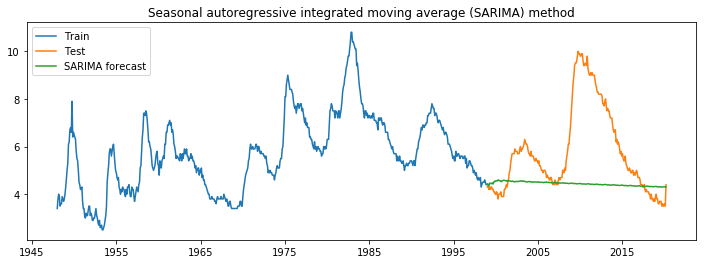

In [378]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [379]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,2.27,22.50
0,Simple average method,1.80,24.82
0,Simple moving average forecast,2.21,21.99
0,Simple exponential smoothing forecast,2.21,22.01
0,Holt's exponential smoothing method,3.99,55.15
0,Holt Winters' additive method,6.32,95.93
0,Holt Winters' multiplicative method,6.38,96.88
0,Autoregressive (AR) method,1.81,25.38
0,Moving Average (MA) method,1.82,24.26
0,Autoregressive moving average (ARMA) method,1.81,25.53


## Seasonal auto regressive integrate moving average with exogenous variable (SARIMAX)

### Import promotion data

In [ ]:
promo = pd.read_csv('promotion.csv', header = None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'], format='%Y-%m')
promo = promo.set_index('Month')
promo

### Split promotion data into train and test data sets

In [ ]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]

### Build SARIMAX model

In [ ]:
model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=promo_train) 
model_fit = model.fit()
print(model_fit.params)

### Recover original time series forecast

In [ ]:
y_hat_sarimax = data_boxcox_diff.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max(), exog=promo_test)
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

### Plot train, test and forecast

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][test.index.min():], label='SARIMAX forecast')
plt.legend(loc='best')
plt.title('SARIMAX method')
plt.show()

### Calculate RMSE and MAPE

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarimax['sarimax_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarimax['sarimax_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results